In [14]:
# Load packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoNormal
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer.autoguide import AutoNormal
from pyro.infer import Predictive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyro.infer import Predictive

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoNormal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split





In [8]:
# Load the data set'
data = pd.read_csv('data/dataset.csv')

# Binary mapping
binary_map = {
    "Gender": {"Male": 0, "Female": 1},
    "OverTime": {"No": 0, "Yes": 1},
    "Over18": {"N": 0, "Y": 1}
}

for col, mapping in binary_map.items():
    if col in data.columns:
        data[col] = data[col].map(mapping)

# One-hot encoding for multi-class categorical columns
categorical_cols = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
data = pd.get_dummies(data, columns=categorical_cols)
# Convert all boolean (True/False) columns to integers (0/1)
data = data.astype({col: int for col in data.select_dtypes(include='bool').columns})

In [9]:
# save the data set to a csv file
data.to_csv('data/data_processed.csv', index=False)

# Print the first 5 rows of the data set
print(data.head())
# Print the shape of the data set
print(data.shape)

   Age Attrition  DailyRate  DistanceFromHome  Education  EmployeeCount  \
0   41       Yes       1102                 1          2              1   
1   49        No        279                 8          1              1   
2   37       Yes       1373                 2          2              1   
3   33        No       1392                 3          4              1   
4   27        No        591                 2          1              1   

   EmployeeNumber  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0               1                        2       1          94  ...   
1               2                        3       0          61  ...   
2               4                        4       0          92  ...   
3               5                        4       1          56  ...   
4               7                        1       0          40  ...   

   JobRole_Laboratory Technician  JobRole_Manager  \
0                              0                0   
1               

In [4]:
# Basic Summary Statistics
print(data.describe())

               Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction       Gender   HourlyRate  \
count     1470.000000              1470.000000  1470.000000  1470.000000   
mean      1024.865306                 2.721769     0.400000    65.891156   
std        602.024335                 1.09

### Correlation

In [5]:
def show_high_correlations(data, threshold):
    corr_matrix = data.corr().abs()  # absolute value of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # upper triangle only

    # Find index pairs with correlation above threshold
    high_corr = upper.stack()[upper.stack() > threshold].sort_values(ascending=False)

    if not high_corr.empty:
        print("Highly correlated feature pairs (>|{:.2f}|):\n".format(threshold))
        for (feat1, feat2), corr_val in high_corr.items():
            print(f"{feat1} ↔ {feat2} : correlation = {corr_val:.3f}")
    else:
        print(f"No feature pairs with correlation above {threshold}.")

# Example usage:
show_high_correlations(data, threshold=0.6)

ValueError: could not convert string to float: 'Yes'

In [6]:
# Make a correlation matrix and print save it to a file
def plot_correlation_matrix(data):
    # Calculate the correlation matrix
    corr = data.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    # Draw the heatmap without annotations
    sns.heatmap(corr, cmap='coolwarm', annot=False, square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')
    plt.show()
# Plot the correlation matrix
plot_correlation_matrix(data)

# Print list of features with more than 70% correlation
def get_high_correlation_features(data, threshold=0.7):
    corr = data.corr()
    high_corr_var = np.where(corr > threshold)
    high_corr_var = [(corr.columns[x], corr.columns[y], corr.iloc[x, y])
                     for x, y in zip(*high_corr_var)
                     if x != y and x < y]
    return high_corr_var

high_corr_features = get_high_correlation_features(data, threshold=0.7)

print("Features with correlation greater than 0.7:")
for f1, f2, value in high_corr_features:
    print(f"{f1} - {f2}: {value:.2f}")

ValueError: could not convert string to float: 'Yes'

### Distribution of the target variable

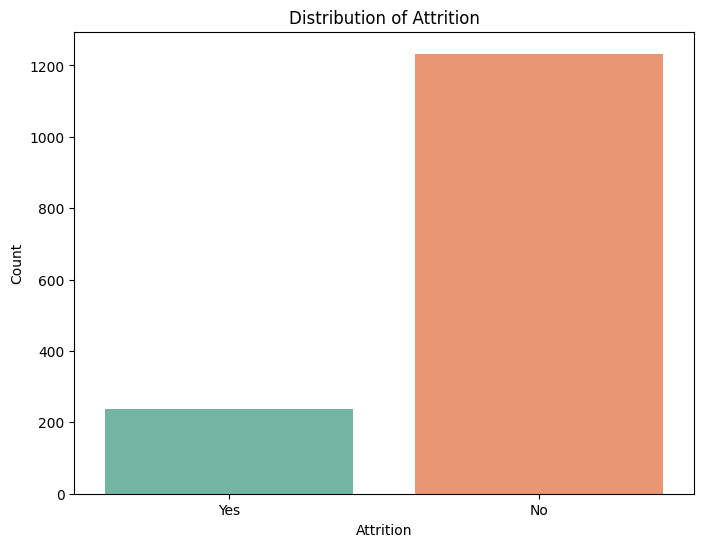

In [10]:
# Plot the distribution of the target variable
def plot_target_distribution(data):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Attrition', data=data, palette='Set2')
    plt.title('Distribution of Attrition')
    plt.xlabel('Attrition')
    plt.ylabel('Count')
    plt.savefig('target_distribution.png')
    plt.show()
# Plot the target distribution
plot_target_distribution(data)

In [11]:
data["Attrition"].value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

### Group-wise analysis

Understand how the target depends on features

This will guide edge creation in your PGM

In [9]:
# Understand how the target depends on features
data.groupby("Age")["Attrition"].mean()

TypeError: agg function failed [how->mean,dtype->object]

### Chi-Square Tests for Categorical Features
Check dependence between two categorical variables

If p-value is small → likely dependency → draw an edge in your PGM.

In [10]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(data["Gender"], data["YearsAtCompany"])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"p-value = {p:.4f}")

p-value = 0.4937


In [11]:
contingency = pd.crosstab(data["Age"], data["YearsAtCompany"])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"p-value = {p:.4f}")

p-value = 0.0000


### Mutual Information (Info-Theoretic Dependency)

For non-linear dependencies (numeric ↔ categorical)

This helps determine which features are informative for predicting attrition, even if not linearly correlated

In [12]:
from sklearn.feature_selection import mutual_info_classif

X = data.drop("Attrition", axis=1)
y = data["Attrition"]
mi = mutual_info_classif(X, y)
print(mi)

[3.02812207e-02 4.32886967e-04 7.51103954e-03 7.80131248e-05
 0.00000000e+00 5.66929074e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.34018033e-03 2.70598254e-02 1.64089354e-02
 3.22091954e-02 1.99710963e-03 1.43214023e-02 7.43377077e-03
 2.90255956e-02 0.00000000e+00 6.97858726e-03 0.00000000e+00
 0.00000000e+00 9.10353681e-03 1.11925850e-02 5.73513890e-03
 1.01448164e-02 1.44581038e-02 5.73051742e-03 0.00000000e+00
 1.30821759e-02 0.00000000e+00 4.63108750e-03 2.36132790e-02
 1.12434445e-04 0.00000000e+00 9.59895331e-03 0.00000000e+00
 1.21993488e-02 1.23647931e-03 1.96461081e-02 0.00000000e+00
 0.00000000e+00 2.21857482e-02 9.52677851e-03 1.34257497e-02
 0.00000000e+00 1.29794500e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.43164491e-02 8.32496367e-04 8.69723708e-03
 1.11998933e-02]


# PPCA

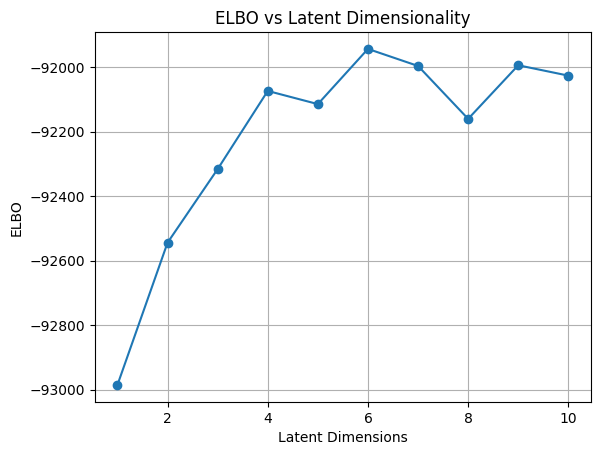

Best latent dimension selected: 6
Reduced dataset saved


In [12]:
np.random.seed(42)

# Load dataset
df = data.drop(columns=[
    "MonthlyIncome",
    "TotalWorkingYears",
    "PerformanceRating",
    "YearsInCurrentRole",
    "YearsWithCurrManager",
    "Department_Human Resources",
    "Department_Sales"
])

# Drop column we are predicting "Attrition"
target = df["Attrition"]
df = df.drop(columns=["Attrition"])

# Standardize safely
X_np = df.to_numpy()
X_mean = np.nanmean(X_np, axis=0)
X_std = np.nanstd(X_np, axis=0)

# Avoid division by zero
X_std[X_std == 0] = 1.0

X = (X_np - X_mean) / X_std
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X = torch.tensor(X, dtype=torch.float32)

# Set latent dimension
latent_dim = 2

# Define PPCA model
def ppca_model(X, latent_dim):
    N, D = X.shape
    W = pyro.sample("W", dist.Normal(0, 1).expand([D, latent_dim]).to_event(2))
    sigma  = pyro.sample("sigma",  dist.HalfCauchy(1)) 
    
    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))
        loc = torch.matmul(z, W.T)
        pyro.sample("obs", dist.Normal(loc, sigma).to_event(1), obs=X)

# Search for best latent dimension
best_latent_dim = None
best_elbo = float('-inf')
best_z_loc = None

elbos = []
dims = list(range(1, 11))  # Dimensions from 1 to 10

for latent_dim in dims:
    pyro.clear_param_store()
    
    def model_wrapped(X):
        return ppca_model(X, latent_dim)

    guide = AutoNormal(model_wrapped)
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model_wrapped, guide, optimizer, loss=Trace_ELBO())
    
    num_steps = 1000
    final_loss = None
    for step in range(num_steps):
        loss = svi.step(X)
        final_loss = loss
    elbo = -final_loss
    elbos.append(elbo)

    if elbo > best_elbo:
        best_elbo = elbo
        best_latent_dim = latent_dim
        best_z_loc = guide(X)["z"].detach().numpy()

# Plot ELBO vs latent dimensions
plt.plot(dims, elbos, marker='o')
plt.xlabel('Latent Dimensions')
plt.ylabel('ELBO')
plt.title('ELBO vs Latent Dimensionality')
plt.grid(True)
plt.show()

print(f"Best latent dimension selected: {best_latent_dim}")

# Save reduced dataset and merge with target
reduced_df = pd.DataFrame(best_z_loc, columns=[f"z{i+1}" for i in range(best_latent_dim)])
reduced_df["Attrition"] = target.values
reduced_df.to_csv("data/reduced_dataset.csv", index=False)

print("Reduced dataset saved")

# BLR

Unique values in y (before training): [-2 -1  0  1  2  3  4  5]
Any non-binary y values? True
X shape: (1470, 4)
y shape: (1470,)
ind shape: (1470,)
num train: 970
num test: 500


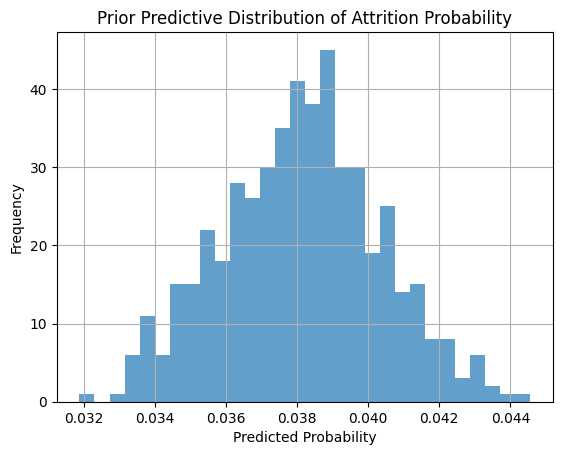

ValueError: Error while computing log_prob at site 'y':
Expected value argument (Tensor of shape (970,)) to be within the support (Boolean()) of the distribution Bernoulli(logits: torch.Size([970])), but found invalid values:
tensor([ 0.,  0.,  3., -1., -1.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0., -1.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  3.,  1.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1., -1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  1.,  0., -1.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0., -1., -1.,  0.,  2.,  0.,  0., -1.,
         0.,  0., -1., -2.,  0.,  0.,  0.,  1.,  0., -1.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
         0., -1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  1., -1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  1., -1.,  0.,  0.,  0.,  1.,  0., -1.,  1., -1., -1., -1.,  0.,
         0., -1.,  0.,  0., -1.,  3.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0., -2.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  2.,  0., -1.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  2.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0., -1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,
         0.,  0.,  1., -1.,  0., -1.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
        -1.,  0., -1., -1., -1.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,
         0.,  0.,  1.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  3.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0., -1.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  1.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0., -2.,  0., -1., -2.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,
        -1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,  1.,  0.,  0.,  0.,
         0.,  0.,  0., -1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1., -1.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0., -1., -1.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  3.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  0., -1.,  3.,  3.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0., -1.,  1.,  0.,  1.,
         0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
         1.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1., -1., -1.,  0.,  1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  2.,
         0.,  0.,  0.,  1., -1.,  0.,  3.,  0., -1.,  0.,  0.,  0., -1.,  0.,
         0.,  2.,  1.,  0.])
 Trace Shapes:          
  Param Sites:          
 Sample Sites:          
     beta dist     | 4 1
         value     | 4 1
      log_prob     |    
intercept dist     |    
         value     |    
      log_prob     |    
        y dist 970 |    
         value 970 |    

In [15]:
## binary logistic regression, using PPCA data set
palette = itertools.cycle(sns.color_palette())

np.random.seed(42) # fix random generator seed (for reproducibility of results)

reduced_data = reduced_df

X = reduced_data.iloc[:, :4].values
y = reduced_data.iloc[:, 4].astype(int).values
print("Unique values in y (before training):", np.unique(y))
print("Any non-binary y values?", np.any((y != 0) & (y != 1)))
ind = y.copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("ind shape:", ind.shape)

train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

epsilon = 1e-6
p = y_train.mean().item()
p = np.clip(p, epsilon, 1 - epsilon)
log_odds = np.log(p / (1 - p))

# Model definition
def model(X, n_cat, y=None):
    n_features = X.shape[1]

    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([n_features, 1]).to_event(2)) # Priors
    intercept = pyro.sample("intercept", dist.Normal(log_odds, 1.0)) # Intercept prior guided by class balance
    logits = X @ beta + intercept  # shape: (N, 1), input features to the bernouli

    with pyro.plate("data", X.shape[0]):
        y = pyro.sample("y", dist.Bernoulli(logits=logits.squeeze(-1)), obs=y)
    
    return y

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

prior_pred = Predictive(model, num_samples=1000)
prior_samples = prior_pred(X_test, n_cat=None, y=None)
logits_prior = X_test @ prior_samples["beta"].mean(0) + prior_samples["intercept"].mean()
probs_prior = torch.sigmoid(logits_prior)

plt.hist(probs_prior.detach().numpy().flatten(), bins=30, alpha=0.7)
plt.title("Prior Predictive Distribution of Attrition Probability")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Clear previous state
pyro.clear_param_store()

# Define guide
guide = AutoNormal(model)

# Optimizer and ELBO
optimizer = ClippedAdam({"lr": 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

# Training loop
n_steps = 40000
for step in range(n_steps):
    loss = svi.step(X_train, n_cat=None, y=y_train.float())
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("beta",))
samples = predictive(X_test, n_cat=None, y=None)  # no y because we want predictions

beta_samples = samples["beta"].detach().squeeze()  # shape: (1000, D)
print("beta_samples shape:", beta_samples.shape)

beta_mean = beta_samples.mean(0)  # shape: (D,)

logits_test = X_test @ beta_mean
probs_test = torch.sigmoid(logits_test)
y_pred = (probs_test > 0.5).int()

accuracy = (y_pred == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy:.3f}")

cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attrition", "Attrition"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (AutoNormal)")
plt.show()

# COMBINED

In [16]:
np.random.seed(42)

# Load dataset
df = pd.read_csv("data/data_processed.csv")
df = df.drop(columns=[
    "MonthlyIncome",
    "TotalWorkingYears",
    "PerformanceRating",
    "YearsInCurrentRole",
    "YearsWithCurrManager",
    "Department_Human Resources",
    "Department_Sales"
])

# Target
target = df["Attrition"].astype(int).values
df = df.drop(columns=["Attrition"])

# Standardize safely
X_np = df.to_numpy()
X_mean = np.nanmean(X_np, axis=0)
X_std = np.nanstd(X_np, axis=0)
X_std[X_std == 0] = 1.0
X_np = (X_np - X_mean) / X_std
X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

# Split the data
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, target, train_size=0.66, random_state=42)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

N_train, D = X_train.shape
latent_dim = 4  # Known from running PPCA seperatelt

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

def combined_ppca_blr_model(X, y=None):
    N, D = X.shape
    
    # PPCA parameters
    W = pyro.sample("W", dist.Normal(0, 1).expand([D, latent_dim]).to_event(2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    
    # Logistic regression parameters
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([latent_dim]).to_event(1))
    intercept = pyro.sample("intercept", dist.Normal(0., 1.))
    
    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))
        
        # Generate X
        loc = torch.matmul(z, W.mT)
        pyro.sample("obs_X", dist.Normal(loc, sigma).to_event(1), obs=X)
        
        # Generate y
        logits = (z * beta).sum(-1) + intercept
        pyro.sample("obs_y", dist.Bernoulli(logits=logits), obs=y)

def ppca_encoder(X, W, sigma):
    D, latent_dim = W.shape
    N = X.shape[0]
    WtW = W.T @ W
    cov_z_inv = WtW + sigma**2 * torch.eye(latent_dim)
    cov_z = torch.inverse(cov_z_inv)
    z_mean = (cov_z @ W.T @ X.T).T
    return z_mean

pyro.clear_param_store()
guide = AutoNormal(combined_ppca_blr_model)
optimizer = Adam({"lr": 0.01})
svi = SVI(combined_ppca_blr_model, guide, optimizer, loss=Trace_ELBO())

num_steps = 10000
for step in range(num_steps):
    loss = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

# Posterior inference using the guide (train set)
posterior_samples = guide(X_train, y_train)
W_mean = posterior_samples['W']
sigma_mean = posterior_samples['sigma']
beta_mean = posterior_samples['beta']
intercept_mean = posterior_samples['intercept']

# Use ppca_encoder for z_test
z_test_encoded = ppca_encoder(X_test, W_mean, sigma_mean)

# Predict on test set
logits_test = (z_test_encoded * beta_mean).sum(-1) + intercept_mean
probs_test = torch.sigmoid(logits_test)
y_pred_test = (probs_test > 0.5).int()

# Accuracy on test set
accuracy_test = (y_pred_test == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy_test:.3f}")

# Confusion matrix for test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.numpy(), y_pred_test.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attrition", "Attrition"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()

ValueError: invalid literal for int() with base 10: 'Yes'